# Reinforcement Learning Notebook
## Introduction to Q-Learning Algorithm
This notebook is inspired by the following notebook: [Deep Reinforcement Learning Course Notebook](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/Taxi-v2/Q%20Learning%20with%20OpenAI%20Taxi-v2%20video%20version.ipynb) 



## The n-Chain environment from OpenAI Gym


The [n-Chain](https://gym.openai.com/envs/NChain-v0/) environment is taken from the OpenAI Gym module (official documentation). It is a simple, toy environment that train reinforcement learning agents.

Within the game an agent can moves along a linear chain of states, using two actions:
* action `0`: move forward along the chain, but get no reward 
* action `1`: move backward to state 0, get small reward of 2

However, the end of the chain offers a large reward of 10, and by moving 'forward' at the end of the chain this large reward can be repeatedly win.

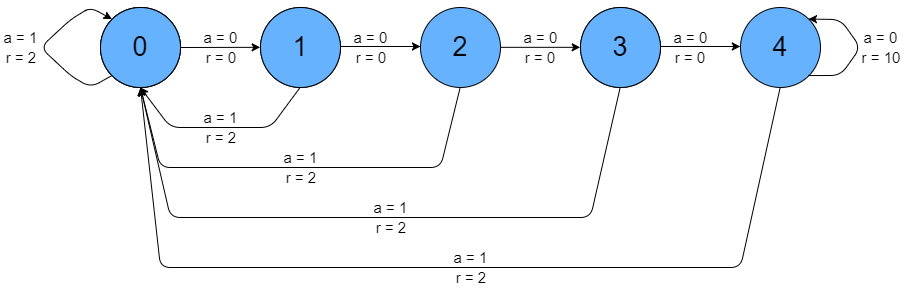

In [16]:
from IPython.display import Image
Image(filename = 'images/NChain-illustration.png', width=1000)
# source: https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/

## Idea of this notebook
Let different q-learning agents play the N-Chain evironment and see how the choosen hyperparameters change the game outcome

- 🤓 Smart Agent 1: the agent explores and takes future rewards into account
- 🤑 Greedy Agent 2: the agent cares only about immediate rewards (small gamma)
- 😳 Shy Agent 3: the agent doesn't explore the environment (small epsilon)



In [17]:
# install the gym module that contains the NChain environment
!pip install gym==0.13.1

In [18]:
# load the necessary python modules
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import random
import gym
import sys
import warnings
import time

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [19]:
# initialize the nchain environment
env = gym.make('NChain-v0')

In [20]:
# get 10 randomly sampled actions
[env.action_space.sample() for ii in range(10)]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

Create the Q-agent class that contains the q-learning algorithm

In [21]:
class Qagent(object):
    """
    Implementation of a Q-learning Algorithm
    """

    def __init__(
        self,
        action_size: int,
        state_size: int,
        learning_parameters: dict,
        exploration_parameters: dict,
        name: str = "agent",
        color: str = "r",
    ) -> None:
        """ initialize the q-learning agent

        Args:
            action_size (int): number of actions the agent can take
            state_size (int): numbe of states the env has
            learning_parameters (dict): learning paramters of the agent
            exploration_parameters (dict): exploration paramters for the agent
            name (str, optional):  set the name of the Q-Agent. Defaults to "agent".
            color (str, optional): set the color of the agent for plotting. Defaults to "r".
        """
        self.name = name
        self.color = color

        self.action_size = action_size
        self.state_size = state_size
        self.qtable = np.zeros((state_size, action_size))

        self.learning_rate = learning_parameters["learning_rate"]
        self.gamma = learning_parameters["gamma"]

        self.epsilon = exploration_parameters["epsilon"]
        self.max_epsilon = exploration_parameters["max_epsilon"]
        self.min_epsilon = exploration_parameters["min_epsilon"]
        self.decay_rate = exploration_parameters["decay_rate"]

    def update_qtable(
        self, state: int, new_state: int, action: int, reward: int, done: bool
    ) -> None:
        """
        update the q-table: Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]

        Args:
          state (int): current state of the environment
          new_state (int): new state of the environment
          action (int): current action taken by agent
          reward (int): current reward received from env
          done (boolean): variable indicating if env is done
        """
        new_qvalue = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :]) * (1 - done)
            - self.qtable[state, action]
        )
        self.qtable[state, action] = (
            self.qtable[state, action] + self.learning_rate * new_qvalue
        )

    def update_epsilon(self, episode: int) -> None:
        """
        reduce epsilon, exponential decay

        Args:
          episode (int): number of episode
        """
        self.epsilon = self.min_epsilon + (
            self.max_epsilon - self.min_epsilon
        ) * np.exp(-self.decay_rate * episode)

    def get_action(self, state: int) -> int:
        """
        select action e-greedy.exploration-exploitation trade-off:
        - exploitation, max value for given state
        - exploration, random choice

        Args:
          state (int): current state of the environment/agent

        Returns:
          action (int): action that the agent will take in the next step
        """
        if random.uniform(0, 1) >= self.epsilon:
            action = np.argmax(self.qtable[state, :])
        else:
            action = np.random.choice(self.action_size)
        return action

    def __str__(self, tablefmt="fancy_grid") -> None:
        """plot the q-table. Generate the table in fancy format.
        """
        headers = [f"Action {action}" for action in range(self.action_size)]
        showindex = [f"State {state}" for state in range(self.state_size)]
        table = tabulate(self.qtable, headers=headers, showindex=showindex, tablefmt="fancy_grid")
        return f"{self.name}\n{table}"


In [22]:
def learn_to_play(agent: Qagent, max_game_steps: int = 10, total_episodes: int = 1000) -> Qagent:
    """
    implementation of the q-learning algorithm, here the q-table values are calculated

    Args:
      max_game_steps (int): number of stepts an agent can take, before the environment is reset
      total_episodes (int): total of training episodes (the number of trials a agent can do)
    """

    rewards = np.zeros(total_episodes)
    epsilons = np.zeros(total_episodes)
    last_states = np.zeros(total_episodes)
    q_averages = np.zeros(total_episodes)

    start = time.time()

    for episode in range(total_episodes):

        state = env.reset()
        game_rewards = 0

        # for each episode loop over the max number of steps that are possible
        # take an action and observe the outcome state (new_state), reward and stopping criterion
        for step in range(max_game_steps):

            action = agent.get_action(state)
            new_state, reward, done, _ = env.step(action)
            agent.update_qtable(state, new_state, action, reward, done)
            state = new_state
            game_rewards += reward

            if done == True:
                break

        rewards[episode] = game_rewards / step
        last_states[episode] = state
        epsilons[episode] = agent.epsilon
        q_averages[episode] = np.sum(agent.qtable)

        # reduce epsilon, for exploration-exploitation tradeoff
        agent.update_epsilon(episode)

        if episode % 300 == 0:
            elapsed_time = round((time.time() - start), 1)
            print(f"elapsed time [sec]: {elapsed_time}, episode: {episode}")

    agent.rewards = rewards
    agent.last_states = last_states
    agent.epsilons = epsilons
    agent.q_averages = q_averages
    return agent

In [23]:
action_size = env.action_space.n
state_size = env.observation_space.n

# Set the training parameters
env.env.slip = 0  # avoid slipping in on the chain

max_game_steps = 10  # Set number of stepts an agent can take, before the environment is reset, 
total_episodes = 1000  # Set total of training episodes (the number of trials a agent can do)    

### Note on learning paramaters
-  gamma = 1: we care about all future rewards equally as the current one 
-  gamma = 0: we only care about the current reward)
-  epsilon: smaller decay rate, more exploration

### 🤓 Smart Agent 1 - the agent explores and takes future rewards into account

In [24]:

name = 'Smart Agent 1 - the agent explores and takes future rewards into accountt'
color = "orange"

learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9 
}  
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1,
    'min_epsilon': 0.0,
    'decay_rate': 0.008
} 

q_agent_1 = Qagent(action_size, state_size, learning_parameters, exploration_parameters, name, color)
q_agent_1 = learn_to_play(q_agent_1, max_game_steps=max_game_steps, total_episodes=total_episodes)

elapsed time [sec]: 0.0, episode: 0
elapsed time [sec]: 0.5, episode: 300
elapsed time [sec]: 1.1, episode: 600
elapsed time [sec]: 1.8, episode: 900


### 🤑 Greedy Agent 2 - the agent cares only about immediate rewards (small gamma)

In [25]:
name = 'Greedy Agent 2 - the agent cares only about immediate rewards (small gamma)'
color =  "m"

learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.01
}   
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.5,
    'min_epsilon': 0.0,
    'decay_rate': 0.008
} 

q_agent_2 = Qagent(action_size, state_size, learning_parameters, exploration_parameters, name, color)
q_agent_2 = learn_to_play(q_agent_2, max_game_steps=max_game_steps, total_episodes=total_episodes)


elapsed time [sec]: 0.0, episode: 0
elapsed time [sec]: 0.8, episode: 300
elapsed time [sec]: 1.3, episode: 600
elapsed time [sec]: 1.7, episode: 900


### 😳 Shy Agent 3 - the agent doesn't explore the environment (small epsilon)

In [26]:
name = "Shy Agent 3 - the agent doesn't explore the environment (small epsilon)"
color = "b"

learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9
} 
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.2,
    'min_epsilon': 0.0,
    'decay_rate': 0.5
} 

q_agent_3 = Qagent(action_size, state_size, learning_parameters, exploration_parameters, name, color)
q_agent_3 = learn_to_play(q_agent_3, max_game_steps=max_game_steps, total_episodes=total_episodes)

elapsed time [sec]: 0.0, episode: 0
elapsed time [sec]: 0.4, episode: 300
elapsed time [sec]: 0.8, episode: 600
elapsed time [sec]: 1.5, episode: 900


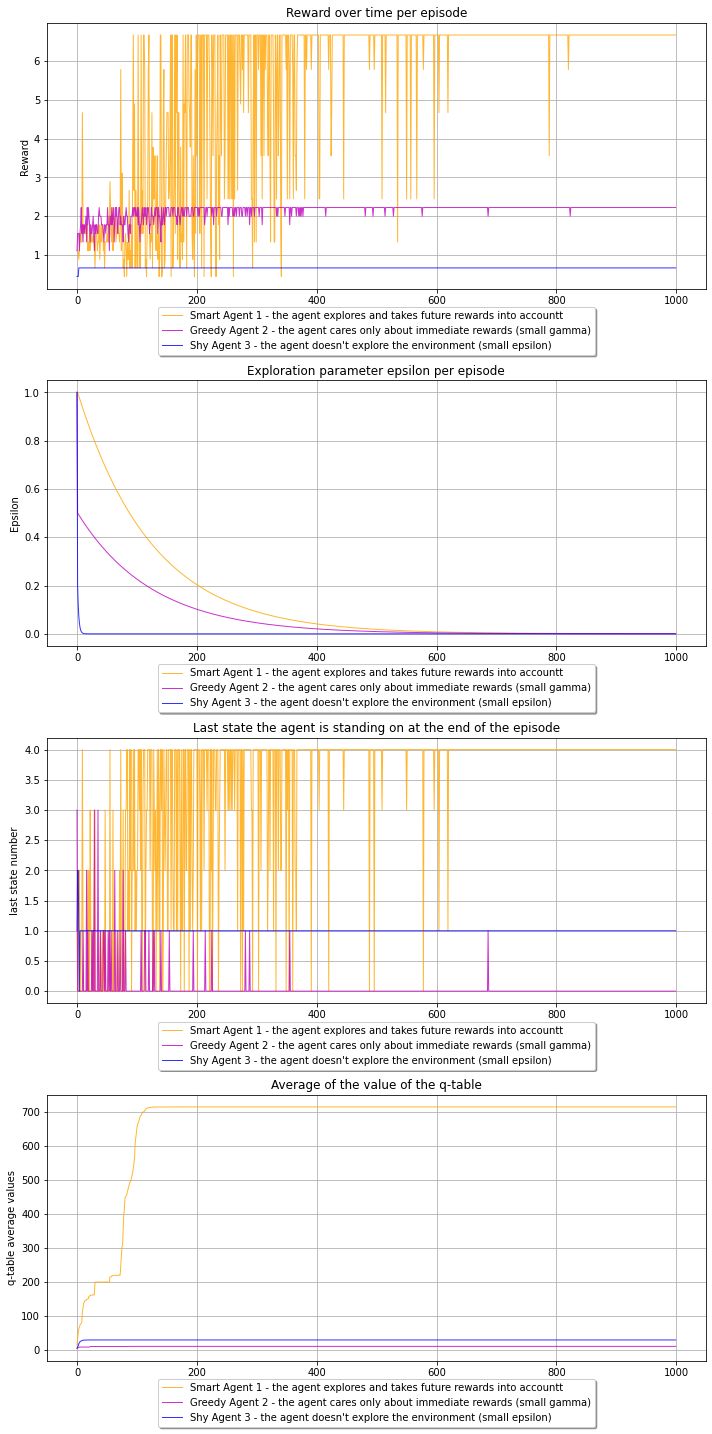

In [27]:
from visualize_plays import VisualizePlays
# visualize the different agents
plays = VisualizePlays(q_agent_1, q_agent_2, q_agent_3)
plays.plot()

## Investigating the q-table values
higher values mean higher future rewards for this specific action-state pair

In [28]:
print(q_agent_1)

Smart Agent 1 - the agent explores and takes future rewards into accountt
╒═════════╤════════════╤════════════╕
│         │   Action 0 │   Action 1 │
╞═════════╪════════════╪════════════╡
│ State 0 │      65.61 │     61.049 │
├─────────┼────────────┼────────────┤
│ State 1 │      72.9  │     61.049 │
├─────────┼────────────┼────────────┤
│ State 2 │      81    │     61.049 │
├─────────┼────────────┼────────────┤
│ State 3 │      90    │     61.049 │
├─────────┼────────────┼────────────┤
│ State 4 │     100    │     61.049 │
╘═════════╧════════════╧════════════╛


The q-table of case1 should have similar values like the following table:

|       | Action 0  | Action 1 | 
| ------------- | ------------- | ------------- |
| State 0 | 65.61  | 61.049  |
| State 1 | 72.9  | 61.049  |
| State 2 | 81.  | 61.049  |
| State 3 | 90.  | 61.049  |
| State 4 | 100.  | 61.049  |

Legend:
- Action 0 = move forward, but get no reward (in the last state get large reward)
- Action 1 = move backward to state 0, get small reward

In [29]:
print(q_agent_2)

Greedy Agent 2 - the agent cares only about immediate rewards (small gamma)
╒═════════╤════════════╤════════════╕
│         │   Action 0 │   Action 1 │
╞═════════╪════════════╪════════════╡
│ State 0 │  0.020202  │    2.0202  │
├─────────┼────────────┼────────────┤
│ State 1 │  0.020202  │    2.0202  │
├─────────┼────────────┼────────────┤
│ State 2 │  0.0160323 │    2.0202  │
├─────────┼────────────┼────────────┤
│ State 3 │  0         │    1.93939 │
├─────────┼────────────┼────────────┤
│ State 4 │  0         │    1.61616 │
╘═════════╧════════════╧════════════╛


In [ ]:
print(q_agent_3)